# Intro
In this project, I aim to train a convolutional neural network based on pictures(patches) extracted from different Pathology Images with different resolution levels. Then using this model to make a prediction on unseen Pathology Images. In the end, vitalizing the result through heatmap to make a end-to-end prototype of detecting cancer.


In order to implement this prototype, I will use the patches from **single** resolution levels in this notebook. 


# Set up environment 

##### Install the OpenSlide C library and Python bindings

In [0]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 7 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (177 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 145674 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import random
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


# Download the Pathology Images from Joshua Gordon and renamed them for after use 

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# only run in the first time
# # raname the files name to remove 'Copy of'
# !cd drive/My\ Drive/myslides/; for file in Copy\ of\ *; do mv "$file" "${file#Copy\ of\ }";done;

# Open one training Pathology Images and check it

In [0]:
def open_number_image(number):
  slide_path = '/content/drive/My Drive/myslides/tumor_'+number+'.tif'
  tumor_mask_path = '/content/drive/My Drive/myslides/tumor_'+number+'_mask.tif'
  slide = open_slide(slide_path)
  tumor_mask = open_slide(tumor_mask_path)
  '''
  # need verify of select picture ?
  for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

  # Verify downsampling works as expected
  width, height = slide.level_dimensions[7]
  assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
  assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]
  '''
  return slide, tumor_mask


In [0]:
number = '091'
slide, tumor_mask = open_number_image(number)
# print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
#                                                         slide.level_dimensions[0][0], 
#                                                         slide.level_dimensions[0][1]))

# print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


In [0]:
del slide, tumor_mask

# Extract:
# 1. Patches from a Pathology Image with specific resolution level
# 2. Tissue image 


In [0]:
# code given by Joshua Gorden from start code

# Read a region from the slide
# Return a numpy RBG array
#-------------------------------------------------------------------------------
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

# Read a region from the slide
# Return a zip, the coordinates of tissue in this region
#-------------------------------------------------------------------------------
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

# Return a image 
# Where the color of tissue pixel is (1,0,0), other are grey
#-------------------------------------------------------------------------------
def apply_mask(im, mask, color=(1,0,0)):
    masked = np.zeros(im.shape)
    for x,y in mask: masked[x][y] = color
    return masked

# Get image patches, image mask patches and tissue patches based on the center (x0, y0) at the specific resolution level

In [0]:
def get_patches(level, slide, tumor_mask, x0, y0, patch_size):
  # downsample factor
  downsample_factor = 2**level

  # get patch 
  patch_image = read_slide(slide,
                x = x0-(patch_size//2)*downsample_factor,            
                y = y0-(patch_size//2)*downsample_factor,
                level = level,
                width = patch_size,
                height = patch_size) 
  
  # get tumor mask, only in channel 0, where the tumur is 1, other is 0
  patch_tumor_mask = read_slide(tumor_mask,
                x = x0-(patch_size//2)*downsample_factor,
                y = y0-(patch_size//2)*downsample_factor,
                level = level,
                width = patch_size,
                height = patch_size)
  patch_tumor_mask = patch_tumor_mask[:,:,0]

  # get patch_tissue, the value of tissue pixel is (1,0,0) 
  tissue_pixel = list(find_tissue_pixels(patch_image))

  patch_tissue = apply_mask(patch_image, tissue_pixel)

  return patch_image, patch_tumor_mask, tissue_pixel, patch_tissue

# Check whether the center of a patch has tumor


In [0]:
# return true or false
def check_center(patch_tumor_mask, patch_center_size, patch_size):
  # get vertex_of_center
  vertex_of_center = (patch_size-patch_center_size)//2

  # check 
  score = np.sum(patch_tumor_mask[vertex_of_center:vertex_of_center+patch_center_size, vertex_of_center:vertex_of_center+patch_center_size])

  return score>0

# Plot the patch

In [0]:
def plot_patch(number, level, patch_image, patch_tumor_mask, patch_size, patch_center):
  half_side = int((patch_size-patch_center)/2)

  fig, axes = plt.subplots(1,2, figsize=(10,5))
  
  # patch_image
  a = axes[0]
  a.imshow(patch_image)
  a.set_title('Picture:%s, level:%d'%(number, level))

  # patch_tumor_mask
  cmap = plt.cm.jet
  colors = cmap(patch_tumor_mask)
  colors[..., -1] = patch_tumor_mask
  a = axes[1]
  a.imshow(patch_image)
  a.imshow(colors, cmap='jet', alpha=0.8)
  a.plot([half_side, half_side+patch_center, half_side+patch_center, half_side, half_side],
         [half_side, half_side, half_side+patch_center, half_side+patch_center, half_side], 'r')
  a.set_title('Cancer(blue) in red')


# get dataset from select_images

In [0]:
# return dataset_patch and dataset_label

def get_dataset(level, patch_size, patch_center, select_image):
  dataset_patch = []
  dataset_label = []

  for number in select_image:
    slide, tumor_mask = open_number_image(number)

    # get whole image of number image
    whole_image = read_slide(slide,
              x = 0,
              y = 0,
              level = level,
              width = slide.level_dimensions[4][0],
              height = slide.level_dimensions[4][1]) 
    
    whole_tumor_mask = read_slide(tumor_mask,
                x = 0,
                y = 0,
                level = level,
                width = slide.level_dimensions[4][0],
                height = slide.level_dimensions[4][1])
    whole_tumor_mask = whole_tumor_mask[:,:,0]

    # get tumor pixels from level 4
    tumor_pixel = np.nonzero(whole_tumor_mask)

    # get tissue pixel from level 4
    tissue_pixel = find_tissue_pixels(whole_image)
    
    # get health tissue pixels from level 4
    tissue_image = apply_mask(whole_image, tissue_pixel) # in 0 channel, value of tissue is 1, other is 0
    health_tissue = tissue_image[:,:,0]-whole_tumor_mask
    health_tissue_pixel = np.nonzero(health_tissue)

    # get tumor patch
    sample_number = 500
    tumor_sample = random.sample(list(zip(tumor_pixel[1],tumor_pixel[0])), sample_number)

    num_per_image = 0
    for i in range(sample_number):
      tumor_coordinate = tumor_sample[i]
      x0 = tumor_coordinate[0]*(2**level)
      y0 = tumor_coordinate[1]*(2**level)

      # get tumor patch on level 4
      patch_image, patch_tumor_mask, tissue_pixel, patch_tissue = get_patches(level, slide, tumor_mask, x0, y0, patch_size)
      
      # Get valid patch where the tissue is more than 50% of this patch
      if (len(tissue_pixel)/(patch_size**2))>0.5:
        dataset_patch.append(patch_image)
        dataset_label.append(1)
        num_per_image += 1
      if num_per_image == 100:
        plot_patch(number, level, patch_image, patch_tumor_mask, patch_size, patch_center)
        break
    
    # get health tissue patch
    health_tissue_sample = random.sample(list(zip(health_tissue_pixel[1],health_tissue_pixel[0])), sample_number)

    num_per_image = 0
    for i in range(sample_number):
      health_tissue_coordinate = health_tissue_sample[i]
      x0 = health_tissue_coordinate[0]*(2**level)
      y0 = health_tissue_coordinate[1]*(2**level)

      # get health tissue patch on level 4
      patch_image, patch_tumor_mask, tissue_pixel, patch_tissue = get_patches(level, slide, tumor_mask, x0, y0, patch_size)

      # Get valid patch where the tissue is more than 50% of this patch
      if (len(tissue_pixel)/(patch_size**2))>0.5:
        dataset_patch.append(patch_image)
        dataset_label.append(0)
        num_per_image += 1
      if num_per_image == 100:
        plot_patch(number, level, patch_image, patch_tumor_mask, patch_size, patch_center)
        break
  
  return dataset_patch, dataset_label

# get train patch and test patch

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


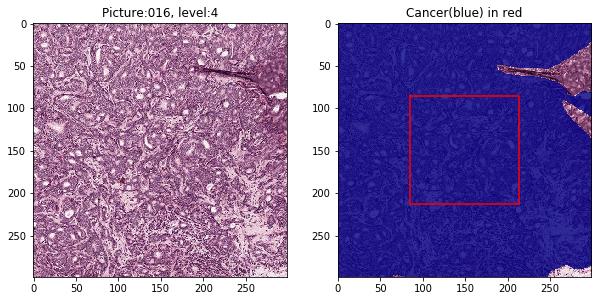

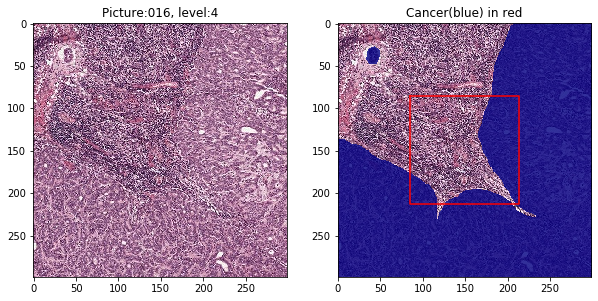

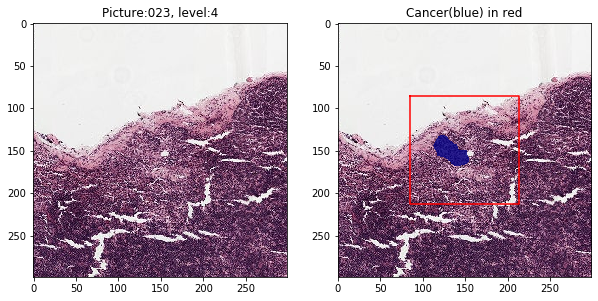

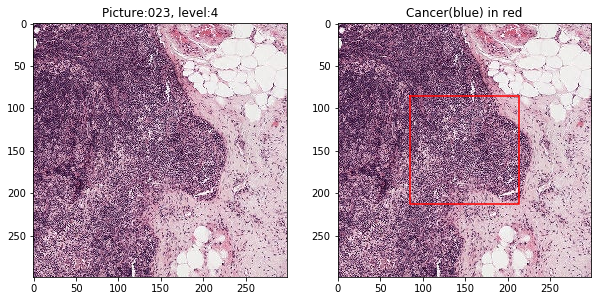

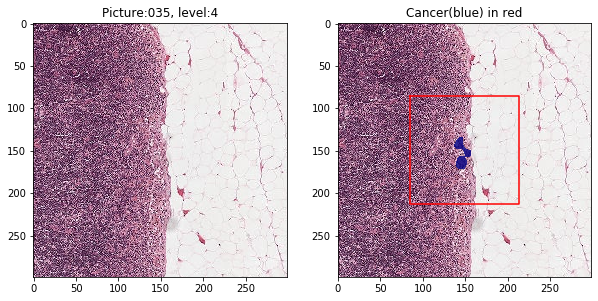

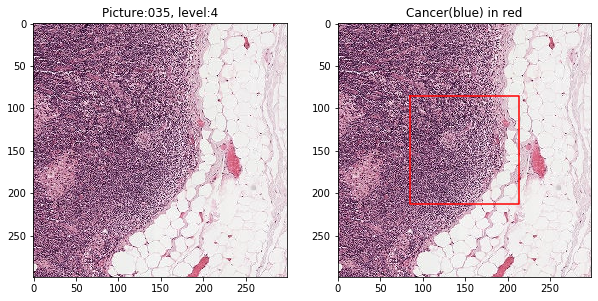

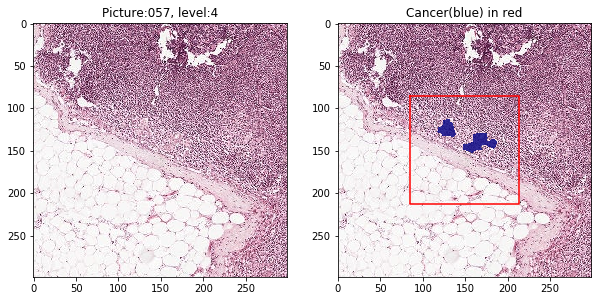

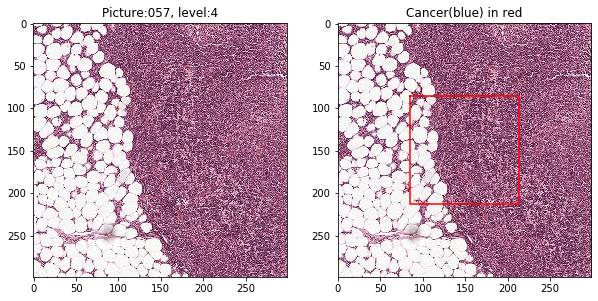

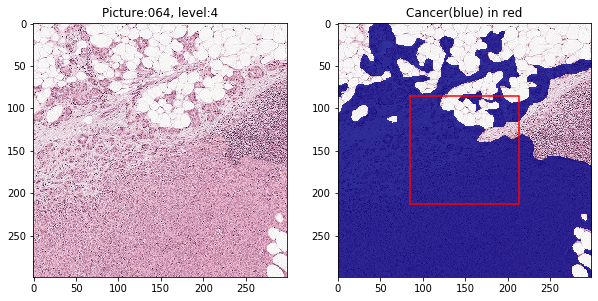

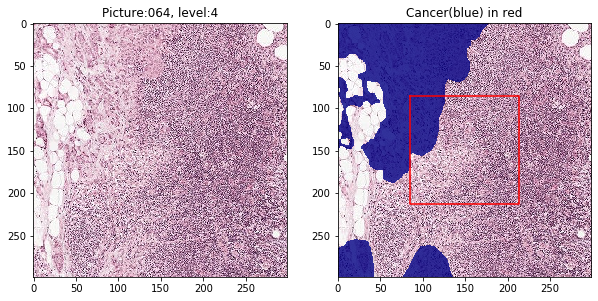

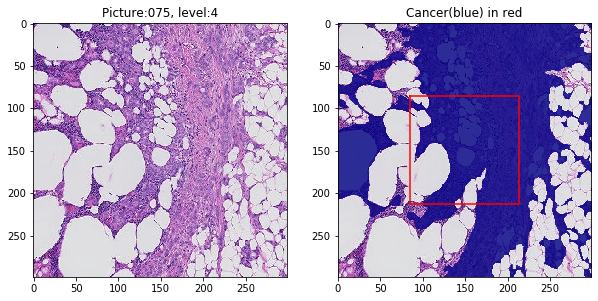

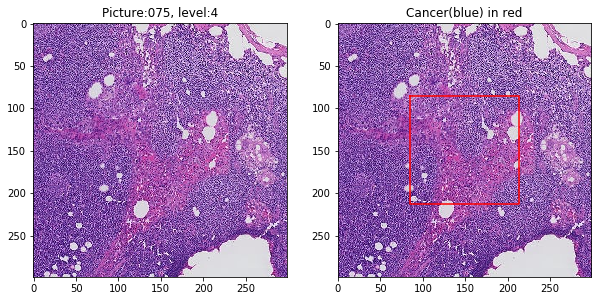

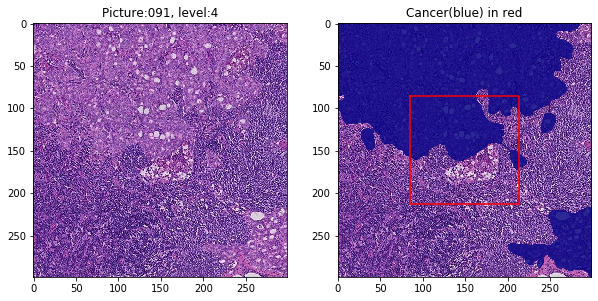

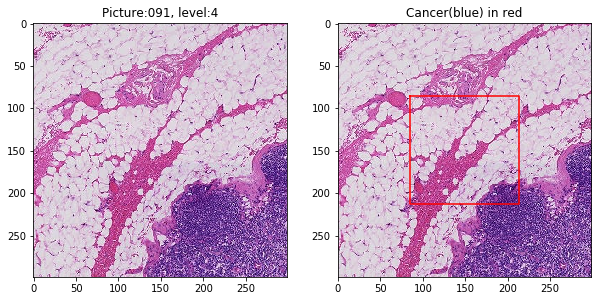

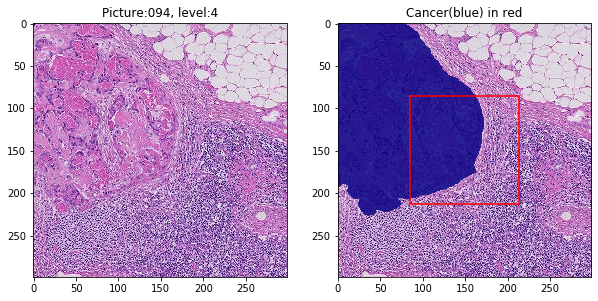

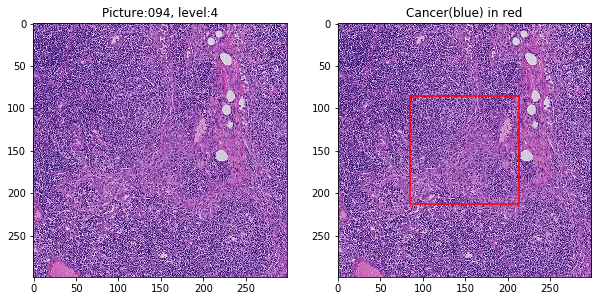

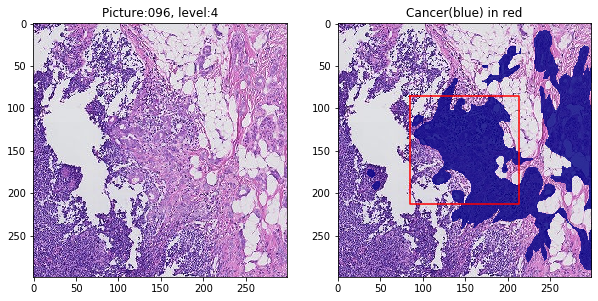

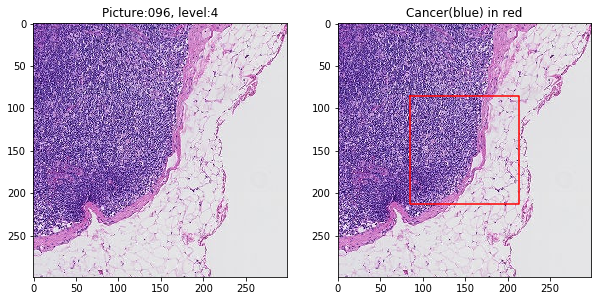

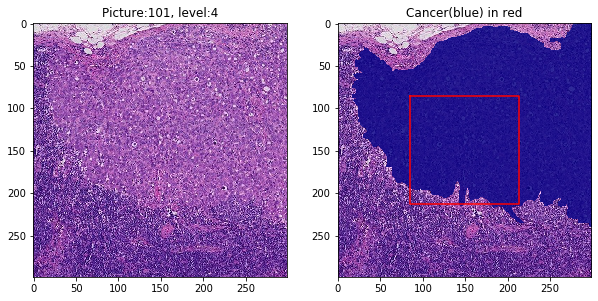

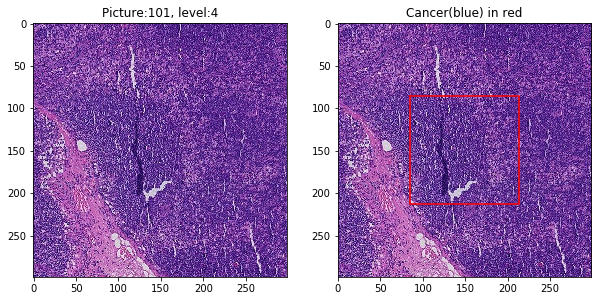

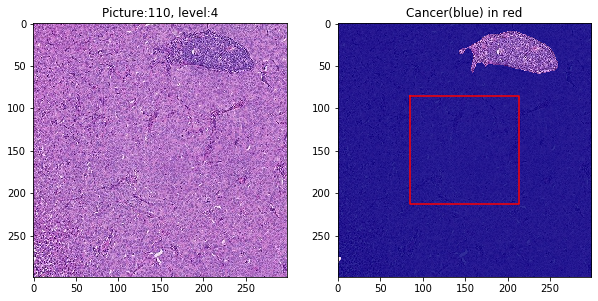

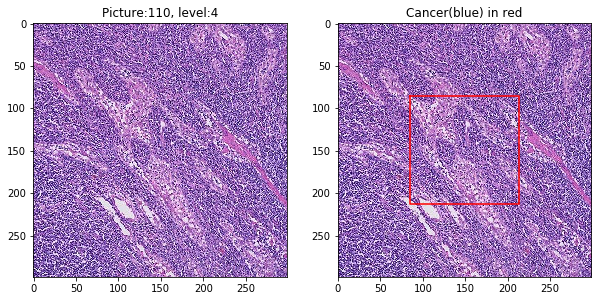

In [0]:
# extract from 10 images, each image extract 100 tumor tissue and 100 health tissue
# 2000 images totally
level = 4
patch_size = 299
patch_center = 128

train_image = ['016','023','035','057','059','064','075','081','094','096']
test_image = ['110']
train_patch, train_label = get_dataset(level, patch_size, patch_center, train_image)
test_patch, test_label = get_dataset(level, patch_size, patch_center, test_image)

# check dataset

In [0]:
patch_trains = np.asarray(train_patch)
label_trains = np.asarray(train_label)

patch_test = np.asarray(test_patch)
label_test = np.asarray(test_label)

print('patch_train shape:%s \nlabel_train shape:%s \npatch_test shape:%s \nlabel_test_shape:%s'%(patch_trains.shape,label_trains.shape,patch_test.shape,label_test.shape))

patch_train shape:(2000, 299, 299, 3) 
label_train shape:(2000,) 
patch_test shape:(200, 299, 299, 3) 
label_test_shape:(200,)


In [0]:
del train_patch, train_label, test_patch, test_label

# preprocess the data

##### Split train and validation data

In [0]:
patch_train, patch_val, label_train, label_val = train_test_split(patch_trains, label_trains, test_size=0.2)

In [0]:
print('patch_train shape:%s \npatch_val shape:%s \npatch_test shape:%s'%(patch_train.shape,patch_val.shape,patch_test.shape))

patch_train shape:(1600, 299, 299, 3) 
patch_val shape:(400, 299, 299, 3) 
patch_test shape:(200, 299, 299, 3)


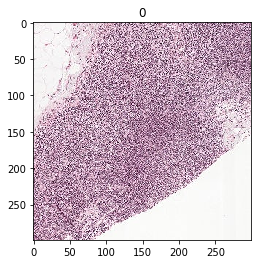

In [0]:
plt.imshow(patch_train[1])
plt.title(label_train[1])
plt.show()

##### rescale image to [0,1]

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

##### set batch = 32


In [0]:
train_generator = train_datagen.flow(patch_train, label_train, batch_size=32, shuffle=True)
val_generator = train_datagen.flow(patch_val, label_val, batch_size=32, shuffle=True)
test_generator = train_datagen.flow(patch_test, label_test, batch_size=32, shuffle=True)

In [0]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 299, 299, 3)
labels batch shape: (32,)


In [0]:
len(train_generator)

50

In [0]:
del patch_train, label_train, patch_val, label_val, patch_test, label_test

# Model

##### Define model

In [0]:
from tensorflow.keras.layers import Dense, concatenate, Flatten, Dropout, Conv2D, BatchNormalization, Activation, MaxPooling2D, Input
from tensorflow.keras.models import Model, Sequential

In [0]:
model = tf.keras.Sequential([

    Conv2D(32, kernel_size=(5, 5), input_shape=(299, 299, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(32, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2, 2)),

    
    Conv2D(64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2, 2)),


    Conv2D(128, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2D(128, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2, 2)),


    Flatten(),
    Dense(128, activation='relu'),
    Dropout(.5),
    Dense(1, activation='sigmoid')    
])

In [0]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 299, 299, 32)      2432      
_________________________________________________________________
batch_normalization_6 (Batch (None, 299, 299, 32)      128       
_________________________________________________________________
activation_6 (Activation)    (None, 299, 299, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 299, 299, 32)      9248      
_________________________________________________________________
batch_normalization_7 (Batch (None, 299, 299, 32)      128       
_________________________________________________________________
activation_7 (Activation)    (None, 299, 299, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 149, 149, 32)     

##### Train and save model

In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=50,
      epochs=10,
      validation_data=val_generator,
      validation_steps=13)
# model.save('/content/drive/My Drive/Colab Notebooks/model_single')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 50 steps, validate for 13 steps
Epoch 1/10
50/50 [==============================] - 28s 562ms/step - loss: 0.6657 - accuracy: 0.6950 - val_loss: 0.5306 - val_accuracy: 0.7450
Epoch 2/10
50/50 [==============================] - 14s 288ms/step - loss: 0.2275 - accuracy: 0.9013 - val_loss: 0.3465 - val_accuracy: 0.8500
Epoch 3/10
50/50 [==============================] - 14s 289ms/step - loss: 0.0780 - accuracy: 0.9700 - val_loss: 0.2970 - val_accuracy: 0.8875
Epoch 4/10
50/50 [==============================] - 14s 287ms/step - loss: 0.0302 - accuracy: 0.9881 - val_loss: 0.3308 - val_accuracy: 0.9050
Epoch 5/10
50/50 [==============================] - 14s 289ms/step - loss: 0.0210 - accuracy: 0.9919 - val_loss: 0.2928 - val_accuracy: 0.9125
Epoch 6/10
50/50 [==============================] - 14s 288ms/step - loss: 0.0052 - accuracy: 0.9981 - val_loss: 0.3275 - val_accuracy: 0.9375
Epoch 7/10
50/50 [==============================] 

##### Plot the result

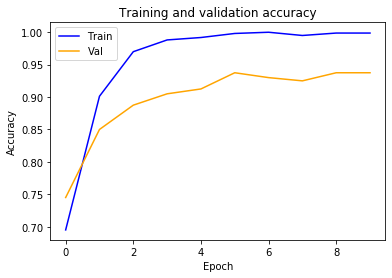

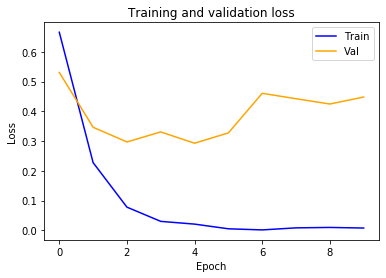

In [0]:
def plot(history):

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  
plot(history)

##### Evaluation

In [0]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('Test loss: %.3f, accuracy: %.3f' % (test_loss, test_acc))

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']
Test loss: 0.280, accuracy: 0.835


##### Load model from colab

In [0]:
# model_name = '/content/drive/My Drive/Colab Notebooks/model_single'
# model_filename = model_name + '_MODEL.h5' 
# model = load_model(model_filename)

# Heatmap

##### Choose picture and plot the origin and cencer

In [0]:
def get_origin_patch_at_certain_level(number, heatmap_level):
  slide, tumor_mask = open_number_image(number)

  # get original image on heatmap_level
  origin_image = read_slide(slide, 
                            x=0, 
                            y=0, 
                            level=heatmap_level, 
                            width=slide.level_dimensions[heatmap_level][0], 
                            height=slide.level_dimensions[heatmap_level][1])

  origin_tumor_mask = read_slide(tumor_mask, 
                            x=0, 
                            y=0, 
                            level=heatmap_level, 
                            width=slide.level_dimensions[heatmap_level][0], 
                            height=slide.level_dimensions[heatmap_level][1])
  origin_tumor_mask = origin_tumor_mask[:,:,0]

  tissue_pixel = list(find_tissue_pixels(origin_image))

  origin_tissue = apply_mask(origin_image, tissue_pixel)

  # plot the original image on heatmap_level 
  fig, axes = plt.subplots(1,2, figsize=(20,10))

  # patch_image
  a = axes[0]
  a.imshow(origin_image)
  a.set_title('Picture:%s, level:%d'%(number, heatmap_level))

  # patch_tumor_mask
  cmap = plt.cm.jet
  colors = cmap(origin_tumor_mask)
  colors[..., -1] = origin_tumor_mask
  a = axes[1]
  a.imshow(origin_image)
  a.imshow(colors, cmap='jet', alpha=0.8)
  a.set_title('Cancer tissue in blue')
  print('shape of level',heatmap_level, 'is :',(slide.level_dimensions[heatmap_level][0], slide.level_dimensions[heatmap_level][1]))
  return origin_image, origin_tumor_mask, origin_tissue, slide, tumor_mask

In [0]:
number = '101'
heatmap_level = 7
get_patch_level = 4

shape of level 7 is : (1088, 560)


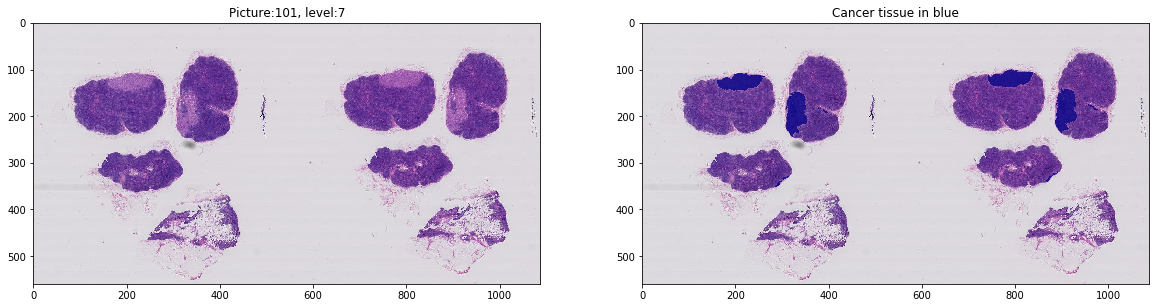

In [0]:
image = get_origin_patch_at_certain_level(number, heatmap_level)

##### Define heatmap

In [0]:
def heatmap(image, heatmap_level, get_patch_level, patch_size, patch_center):
  heatmap = np.zeros((image[3].level_dimensions[heatmap_level][1], image[3].level_dimensions[heatmap_level][0]))

  step = 10

  x_h = []
  y_h = []
  eval_patch = []
  true = []
  pred = []

  for x in range(50, image[3].level_dimensions[heatmap_level][1]-50, step):
    for y in range(50, image[3].level_dimensions[heatmap_level][0]-50, step):
      if image[2][x,y,0]==1:
        x_h.append(x)
        y_h.append(y)
        x0 = x*(2**7)
        y0 = y*(2**7)
        # get patch at get_patch_level
        patch_image, patch_tumor_mask, tissue_pixel, patch_tissue = get_patches(get_patch_level, image[3], image[4], y0, x0, patch_size)
        eval_patch.append(patch_image)
        # get the true value
        true_label = check_center(patch_tumor_mask, patch_center, patch_size)
        true.append(true_label)
        eval_patch_train = np.asarray(eval_patch)
        pred_label = model.predict(eval_patch_train/255.)
        pred.extend(pred_label)



  # plot the heatmap

  # assign the predicted value to heatmap the pixel number per assigned is 10*10
  for i in range(len(pred)):
    heatmap[x_h[i]-5:x_h[i]+5, y_h[i]-5:y_h[i]+5] = pred[i][0]
  
  # define the plot
  fig, axes = plt.subplots(1,2, figsize=(10,10), dpi=100)

  cmap = plt.cm.jet
  # True cancer distribution
  colors = cmap(image[1])
  colors[..., -1] = image[1]/np.max(image[1])
  a = axes[0]
  a.imshow(image[0])
  a.imshow(colors, cmap='jet', alpha=0.8)
  a.set_title('TRUE' + number)

  # Predicted cancer distribution
  a = axes[1]
  colors = cmap(heatmap)
  colors[..., -1] = heatmap/np.max(heatmap)
  a.imshow(image[0])
  a.imshow(colors, cmap='jet', alpha=0.8)
  a.set_title('PREDICT')

  plt.show()


##### Plot the heatmap

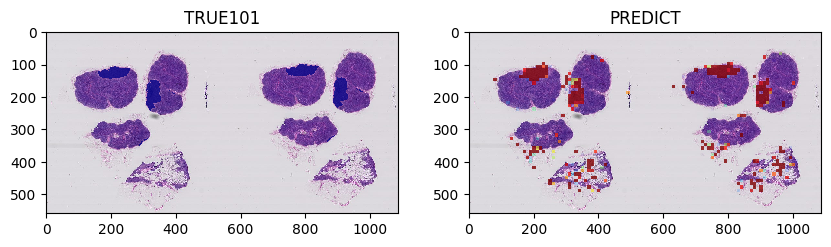

In [0]:
heatmap(image, heatmap_level, get_patch_level, patch_size, patch_center)